In [50]:
import imars3d

from imars3d.backend.dataio.data import load_data, _get_filelist_by_dir
import tomopy
import os

import numpy as np

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
ncore = 10

# Input location 

In [22]:
ct_dir = "/HFIR/CG1D/IPTS-29298/raw/ct_scans/2022_09_29_sample3"
assert os.path.exists(ct_dir)

ob_dir = "/HFIR/CG1D/IPTS-29298/raw/ob/2022_09_30"
assert os.path.exists(ob_dir)

dc_dir = "/HFIR/CG1D/IPTS-29298/raw/df/2022_09_29"
assert os.path.exists(dc_dir)

In [23]:
list_ct_files, list_ob_files, list_dc_files = _get_filelist_by_dir(ct_dir=ct_dir,
                                    ob_dir=ob_dir,
                                    dc_dir=dc_dir)

## loading the data 

In [24]:
%%time
ct, ob, dc, rot_angles = load_data(ct_dir=ct_dir,
                                   ob_dir=ob_dir,
                                   dc_dir=dc_dir,
                                   ct_fnmatch="*.tiff",
                                   ob_fnmatch="*.tiff",
                                   dc_fnmatch="*.tiff")

ct:   0%|          | 0/783 [00:00<?, ?it/s]

ob:   0%|          | 0/5 [00:00<?, ?it/s]

dc:   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 7.47 s, sys: 18.8 s, total: 26.3 s
Wall time: 30.6 s


In [7]:
print(f"{len(ct)=}")
print(f"{type(ct)=}")
print(f"{ct.dtype=}")
print(f"{ct[0,0,0]=}")

len(ct)=1290
type(ct)=<class 'numpy.ndarray'>
ct.dtype=dtype('uint16')
ct[0,0,0]=1331


visualize imported data 

<IPython.core.display.Javascript object>


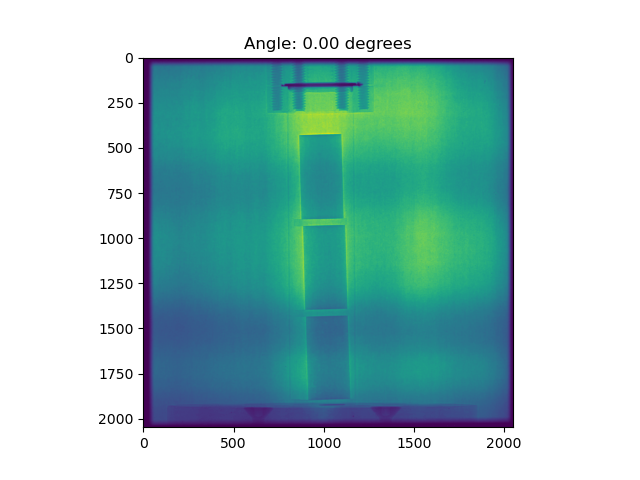

interactive(children=(IntSlider(value=0, description='index', max=783), Output()), _dom_classes=('widget-inter…

In [25]:
plt.figure(1)

def plot_ct(index):
    plt.title(f"Angle: {rot_angles[index]:.2f} degrees")
    plt.imshow(ct[index])
    plt.show()
    
ct_plot_ui = interactive(plot_ct,
                        index=widgets.IntSlider(min=0,
                                               max=len(ct),
                                               value=0))
display(ct_plot_ui)

## OB 

<IPython.core.display.Javascript object>


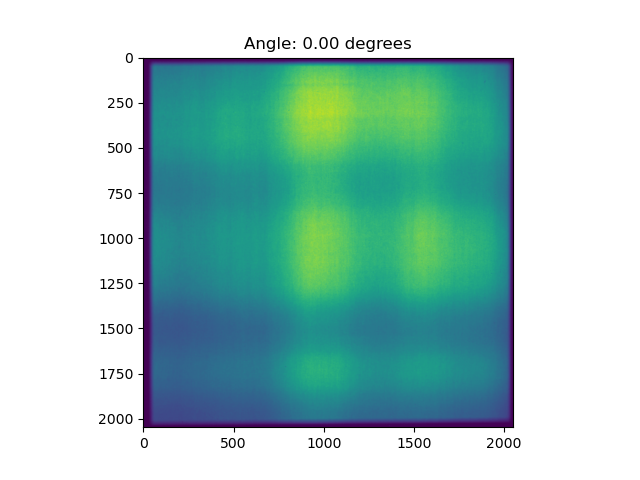

interactive(children=(IntSlider(value=0, description='index', max=5), Output()), _dom_classes=('widget-interac…

In [26]:
plt.figure(2)

def plot_ob(index):
    plt.title(f"Angle: {rot_angles[index]:.2f} degrees")
    plt.imshow(ob[index])
    plt.show()
    
ob_plot_ui = interactive(plot_ob,
                        index=widgets.IntSlider(min=0,
                                               max=len(ob),
                                               value=0))
display(ob_plot_ui)

# Crop

In [27]:
from imars3d.backend.morph.crop import crop, detect_bounds

In [28]:
#%%time
#bounds = detect_bounds(arrays=ob)

In [29]:
#print(bounds)

In [30]:
crop_region = [600, 1350, 100, 1950]    # [left, right, top, bottom]

In [31]:
%%time
ct_crop = crop(arrays=ct,
         crop_limit=crop_region)
ob_crop = crop(arrays=ob,
         crop_limit=crop_region)
dc_crop = crop(arrays=dc,
         crop_limit=crop_region)

CPU times: user 3 ms, sys: 878 ms, total: 881 ms
Wall time: 876 ms


In [32]:
np.shape(ct_crop)

(783, 1850, 750)

<IPython.core.display.Javascript object>


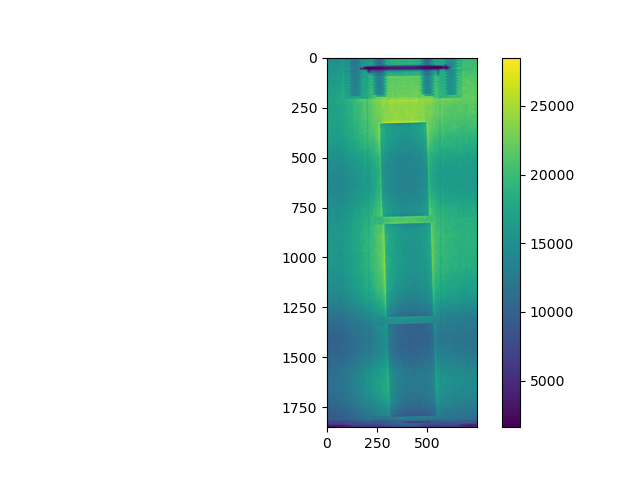

In [33]:
plt.figure()
plt.imshow(ct_crop[0])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


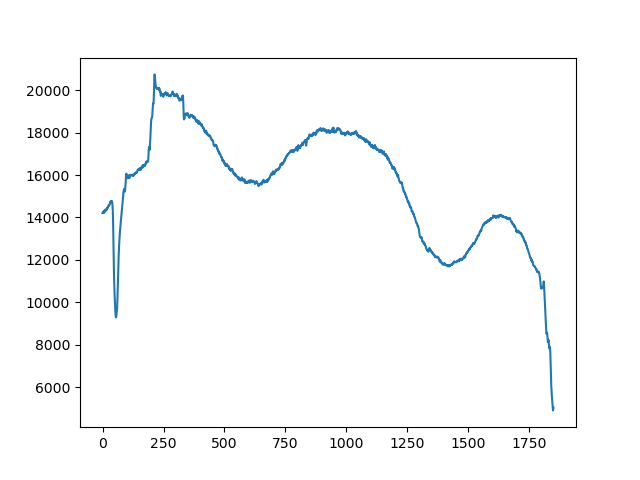

In [34]:
plt.figure()
vertical_profile = np.mean(ct_crop[0][:,0:300], axis=1)
plt.plot(vertical_profile)
plt.show()

## Gamma filtering 

In [35]:
from imars3d.backend.corrections.gamma_filter import gamma_filter

In [36]:
%%time
ct_gamma = gamma_filter(arrays=ct_crop, 
                        selective_median_filter=False, 
                        diff_tomopy=20, 
                        max_workers=48, 
                        median_kernel=3)

CPU times: user 3min 44s, sys: 13.5 s, total: 3min 57s
Wall time: 21.3 s


In [37]:
%%time
#ct_gamma = ct_gamma.astype(np.ushort)
#ob_gamma = ob_gamma.astype(np.ushort)
#ob_gamma = ob_crop.astype(np.ushort)
#dc_gamma = dc_gamma.astype(np.ushort)
#dc_gamma = dc_crop.astype(np.ushort)
ob_gamma = ob_crop
dc_gamma = dc_crop

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 14.3 µs


<IPython.core.display.Javascript object>


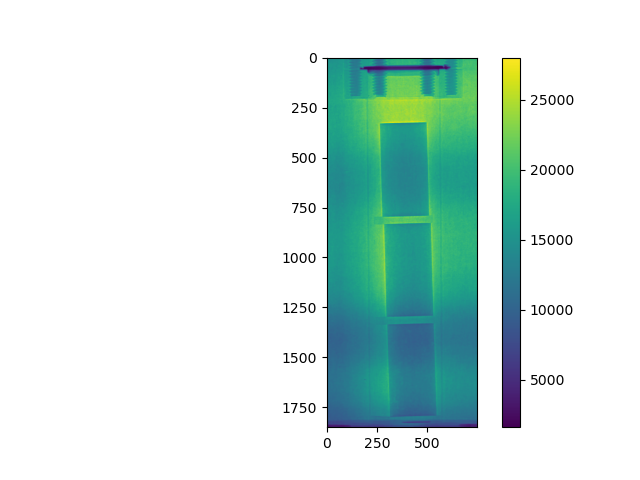

In [38]:
plt.figure(0)
plt.imshow(ct_gamma[0])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


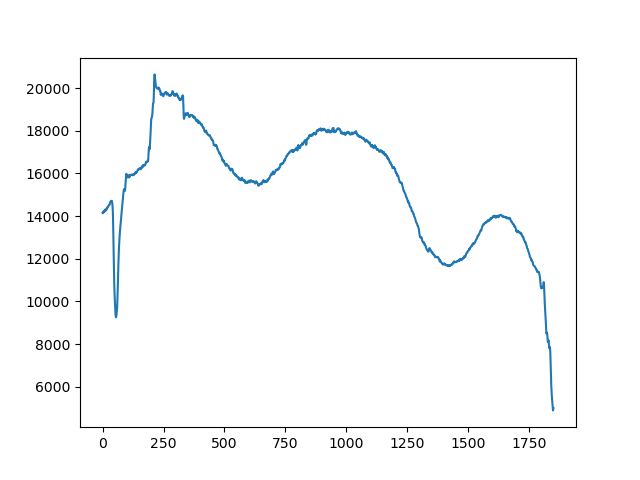

In [39]:
plt.figure()
vertical_profile = np.mean(ct_gamma[0][:,0:300], axis=1)
plt.plot(vertical_profile)
plt.show()

# Normalization

In [40]:
# from imars3d.backend.preparation.normalization import normalization

In [41]:
# %%time
# ct_normalized = normalization(arrays=ct_gamma,
#                               flats=ob_gamma,
#                               darks=dc_gamma)

In [42]:
# print(np.shape(ob_gamma))

In [43]:
# plt.figure(3)
# plt.imshow(ct_normalized[0], vmin=0, vmax=1)
# plt.colorbar()
# plt.show()

### doing the calculation manually while waiting for iMars3D to be fixed !!!

In [44]:
%%time
my_ob = np.median(ob_gamma, axis=0)
my_dc = np.median(dc_gamma, axis=0)

ct_norm = []
for ct in ct_gamma:
    ct_norm.append(np.true_divide(ct-my_dc, my_ob-my_dc))


CPU times: user 8 s, sys: 9.87 s, total: 17.9 s
Wall time: 39.6 s


<IPython.core.display.Javascript object>


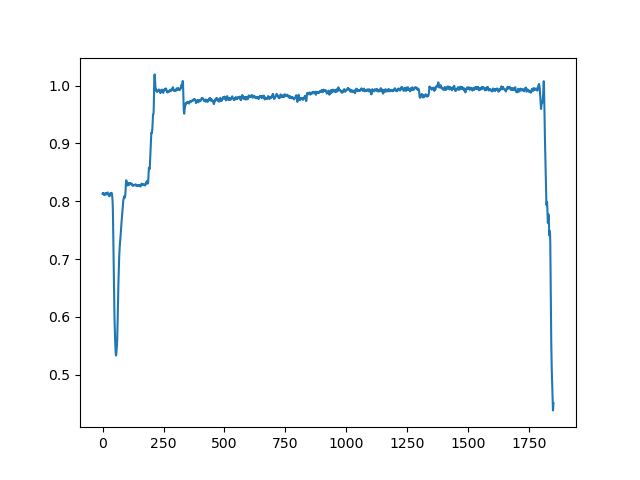

In [45]:
vertical_profile = np.mean(ct_norm[0][:, 0:300], axis=1)
plt.figure()
plt.plot(vertical_profile)
plt.show()

# Beam fluctuations

## using tomopy.normalize_bg

Works great when there is no part of the rotation stage in the field of view. 

In [46]:
from imars3d.backend.corrections.intensity_fluctuation_correction import intensity_fluctuation_correction

In [47]:
# import tomopy
# ct_beam_fluctuation_with_tomopy = tomopy.normalize_bg(ct_norm)

In [ ]:
%%time
ct_beam_fluctuation = intensity_fluctuation_correction(ct=np.asarray(ct_norm),
                                                       air_pixels=200)

In [ ]:
vertical_profile_before = np.mean(ct_normalized[:,400], axis=1)
vertical_profile_after = np.mean(ct_beam_fluctuation_with_tomopy[:, 400], axis=1)
plt.figure(num="using intensity fluctuation correction")
plt.plot(vertical_profile_before, label='normalized')
plt.plot(vertical_profile_after, label='fluctuation correction')
plt.show()
plt.legend()

In [ ]:
plt.figure()
plt.imshow(ct[0] - ct_beam_fluctuation[0])
plt.colorbar()
plt.show()

# using tomopy.normalize_roi

In [51]:
bg_region = [5, 100, 250, 1100]  #  [left, right, top, bottom]

roi = [bg_region[2], bg_region[0],
       bg_region[3], bg_region[1]]

proj_norm_beam_fluctuation = tomopy.prep.normalize.normalize_roi(ct_norm,
                                               roi=roi,
                                               ncore=ncore)

<IPython.core.display.Javascript object>


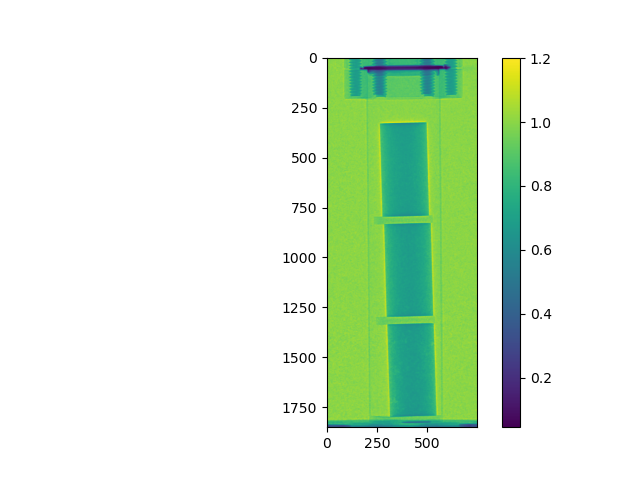

In [53]:
plt.figure()
plt.imshow(proj_norm_beam_fluctuation[0])
plt.colorbar()


# Filter noise 

In [ ]:
# Do not run this on analysis machine... it's taking forever!

In [ ]:
#from imars3d.backend.corrections.denoise import denoise

In [ ]:
#%%time
#ct = denoise(arrays=ct)

In [ ]:
#plt.figure(6)

#def plot_ct(index):
#    plt.title(f"After denoising, Angle: {rot_angles[index]:.2f} degrees")
#    plt.imshow(ct[index])
#    plt.show()
    
#ct_plot_ui = interactive(plot_ct,
#                        index=widgets.IntSlider(min=0,
#                                               max=len(ct),
#                                               value=0))
#display(ct_plot_ui)

# from attunation to transmission 

In [57]:
import tomopy

In [58]:
%%time
proj_mlog = tomopy.minus_log(proj_norm_beam_fluctuation,
                            ncore=48)

CPU times: user 19 s, sys: 2.07 s, total: 21.1 s
Wall time: 935 ms


<IPython.core.display.Javascript object>


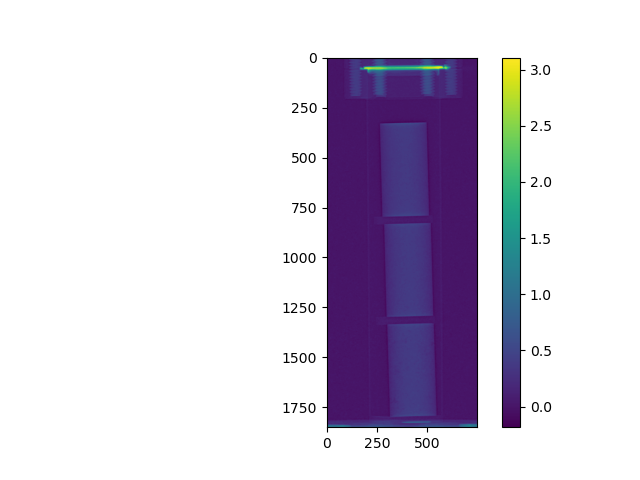

In [59]:
plt.figure(11)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# remove strike artifacts 

In [ ]:
from imars3d.backend.corrections.ring_removal import remove_ring_artifact

In [ ]:
%%time
ct = remove_ring_artifact(arrays=ct)

# find rotation center 

In [ ]:
# find rotation center

In [ ]:
from imars3d.backend.diagnostics.rotation import find_rotation_center

In [ ]:
%%time
rot_center = find_rotation_center(arrays=ct,
                                 angles=rot_angles,
                                 in_degrees=True,
                                 atol_deg=rot_angles[1]-rot_angles[0])

print(f"{rot_center[0] =}")

In [ ]:
# found 761 with atol_deg = 0.1
# found 761 with atol_deg = 0.5 (in 6m38s)
# found 761 with atol_deg = rot_angles[1] - rot_angles[0]

# tilt correction

In [ ]:
from imars3d.backend.diagnostics.tilt import find_180_deg_pairs_idx
from imars3d.backend.diagnostics.tilt import apply_tilt_correction
from imars3d.backend.diagnostics.tilt import calculate_tilt

In [ ]:
list_opposite_angles = find_180_deg_pairs_idx(angles=rot_angles,
                                             atol=0.5)

In [ ]:
list_opposite_angles

In [ ]:
index_0_degree = list_opposite_angles[0][0]
index_180_degree = list_opposite_angles[1][0]

In [ ]:
list_ct_files, list_ob_files, list_dc_diles = _get_filelist_by_dir(ct_dir=ct_dir,
                                    ob_dir=ob_dir,
                                    )

In [ ]:
file_0_degree =  list_ct_files[index_0_degree] 
file_180_degree = list_ct_files[index_180_degree]

print(f"{file_0_degree = }")
print(f"{file_180_degree = }")

# calculate tilt

In [ ]:
%%time
tilt_angle = calculate_tilt(image0=ct[index_0_degree],
                           image180=ct[index_180_degree])
print(f"{tilt_angle.x=}")

In [ ]:
np.shape(ct)

In [ ]:
%%time
ct_tilt_corrected = apply_tilt_correction(arrays=ct,
                                          tilt=tilt_angle.x)

# Reconstruction

In [ ]:
from imars3d.backend.reconstruction import recon

We need to convert the angles from deg to rad

In [ ]:
%%time
rot_ang_rad = np.radians(rot_angles)

In [ ]:
%%time

rst = recon(arrays=ct_tilt_corrected,
           theta=rot_ang_rad,
           center=rot_center[0])

In [ ]:
plt.figure(10)
plt.imshow(rst[:, :, 700], vmax=0.004, vmin=0)
plt.colorbar()
plt.show()